# Setup for GBM

## Imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="notebook", fscale=1, grid=False)

from astromodels import Powerlaw, Exponential_cutoff, Constant, Band
from astromodels.utils.configuration import astromodels_config
astromodels_config.modeling.ignore_parameter_bounds = True

from gbmbkgpy.modeling.new_astromodels import SBPL

from gbmbkgpy.data.gbm_data import GBMData

from gbmbkgpy.geometry.gbm_geometry import GBMGeometryPosHist

from gbmbkgpy.response.gbm_response import GBMResponseGenerator
from gbmbkgpy.response.response_precalculation import ResponsePrecalculation
from gbmbkgpy.response.src_response import EarthResponse, CGBResponse, GalacticCenterResponse, PointSourceResponse

from gbmbkgpy.modeling.source import PhotonSourceFixed, SAASource, NormOnlySource
from gbmbkgpy.modeling.functions import AstromodelFunctionVector

from gbmbkgpy.modeling.model import ModelDet

from gbmbkgpy.io.plotting.plot import plot_lightcurve

## DATA

In [2]:
# get daily GBM data
gbmdata = GBMData(name="gbmn0", 
                date="200510", 
                data_type="ctime", 
                detector="n6", 
                echans=["1","2","3-5"])

# Rebin the data to 20 second bins
gbmdata.rebin_data(min_bin_width=20)

## GEOMETRY

In [3]:
# init geometry object for Fermi/GBM at the given date
geom = GBMGeometryPosHist(date="200510")

## Response

In [4]:
# General response Generator
drm_gen1 = GBMResponseGenerator(geometry=geom, det="n6", Ebins_in_edge=np.geomspace(10,2000, 101), data=gbmdata)

# Response precalculation for extended sources
rsp_pre1 = ResponsePrecalculation(drm_gen1, Ngrid=10000)

/opt/hostedtoolcache/Python/3.9.15/x64/lib/python3.9/site-packages/responsum-1.0.2-py3.9.egg/responsum/response.py:108: RuntimeWarning: Minimum MC energy (10.0) is larger than minimum EBOUNDS energy (5.307523250579834)


### Responses for extended sources

In [5]:
# Time where to calculate the effective responses - linear interpolation in between
interp_time = np.linspace(gbmdata.time_bins[0,0], gbmdata.time_bins[-1,-1], 800)

# Galactic Center
gc_rsp = GalacticCenterResponse(geometry=geom, interp_times=interp_time, resp_prec=rsp_pre1)

# Earth Albedo
earth_rsp = EarthResponse(geometry=geom, interp_times=interp_time, resp_prec=rsp_pre1)

# CGB
cgb_rsp = CGBResponse(geometry=geom, interp_times=interp_time, resp_prec=rsp_pre1)

### Response for point source

In [6]:
# Response for Crab
crab_rsp = PointSourceResponse(response_generator=drm_gen1, interp_times=interp_time, ra=83.633, dec=22.015)

## Modelling

### Photon sources

We use [astromodels](https://github.com/threeML/astromodels) to define the spectra and combine this with the precalculated responses for the different sources.

In [7]:
# A point source

# Define spectrum
pl_crab = Powerlaw()
pl_crab.K.value = 9.7
pl_crab.index.value = -2.1

# define source
crab = PhotonSourceFixed("Crab", pl_crab, crab_rsp)


# extended sources

#EARTH
earth_spec = SBPL()
earth_spec.K.value = 0.015
earth_spec.alpha.value = -5
earth_spec.beta.value = 1.72
earth_spec.xb.value = 33.7

earth = PhotonSourceFixed("Earth", earth_spec, earth_rsp)

#CGB
cgb_spec = SBPL()
cgb_spec.K.value = 0.11
cgb_spec.alpha.value = 1.32
cgb_spec.beta.value = 2.88
cgb_spec.xb.value = 30.0
cgb = PhotonSourceFixed("CGB", cgb_spec, cgb_rsp)

#GC
pl1_gc = Powerlaw()
pl1_gc.K.value = 0.08737610581967094
pl1_gc.index.value = -1.45

pl2_gc = Powerlaw()
pl2_gc.K.value = 252.3829377920772
pl2_gc.index.value = -2.9

exp_gc = Exponential_cutoff()
exp_gc.K.value = 0.1036025649336684
exp_gc.xc.value = 8

total = pl1_gc+pl2_gc+exp_gc

gc = PhotonSourceFixed("GC", total, gc_rsp)

### SAA

The de-excitation after an SAA transit is modelled as a simple exponential decay. But it is different for different energy channels and we have no info how to combine these. Therefore every energy channel gets an independent SAA Decay assigned.

In [8]:
exp_decay = Exponential_cutoff()
exp_decay.K.value = 1000
exp_decay.xc.value = 5000
afv_saa = AstromodelFunctionVector(gbmdata.num_echan, base_function=exp_decay)

exit_time_saa = gbmdata.mean_time[100]

saa = SAASource("SAA", exit_time_saa, afv_saa)

### Cosmic Rays

Because we don't have a response for charged particles, we can not forward fold the signal due to the incoming Cosmic Rays. We therefore rely on good tracers of the effect. For GBM for example the McIlwain L-parameter seems to be a decent tracer. The time variablity is given by this tracer and only a total normalization (per energy channel) is fitted.

In [9]:
c = Constant()
c.k.value = 100
afv_cr = AstromodelFunctionVector(gbmdata.num_echan, base_function=c)

cr = NormOnlySource("CR", geom.cr_tracer, afv_cr)

## Create Model

In [10]:
model = ModelDet(gbmdata)

model.add_source(gc)
model.add_source(earth)
model.add_source(cgb)
model.add_source(crab)

model.add_source(saa)
model.add_source(cr)

## Plot

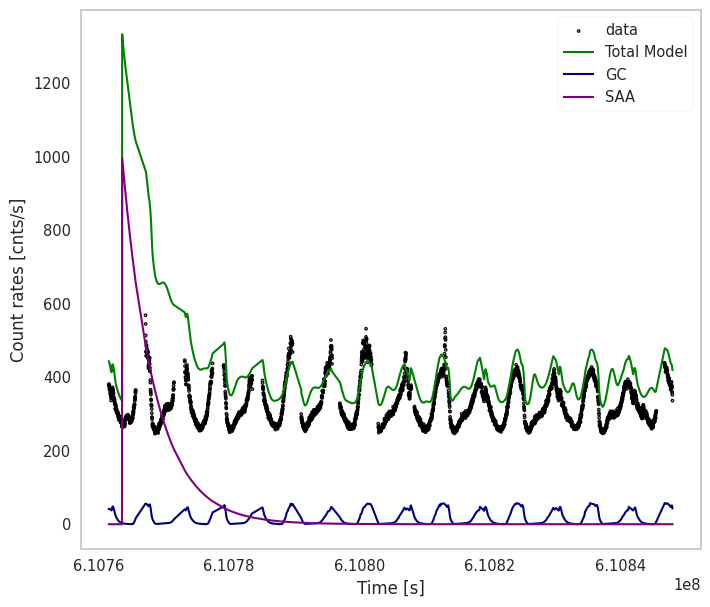

In [11]:
ax = plot_lightcurve(model, eff_echan=0, model_component_list=["GC", "SAA"], model_component_colors=["navy", "purple"])
ax.legend()

Generate new data from our model

Text(0, 0.5, 'Counts')

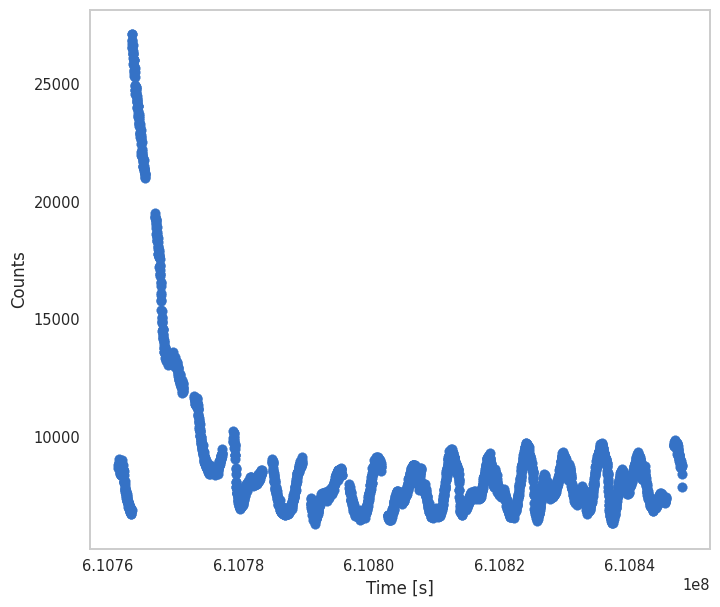

In [12]:
plt.scatter(gbmdata.mean_time, model.generate_counts()[:,0])
plt.xlabel("Time [s]")
plt.ylabel("Counts")